In [36]:
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
from matplotlib.colors import ListedColormap
import scipy.optimize
import jax
from jax.nn import softmax
from jax import grad, jit
import jax.numpy as jnp
from jax.experimental import optimizers
import time
%run Dendrogram.ipynb

In [2]:
def energy(params, locs, masses, weights):        

    E = 0
    c0 = 100
    c1 = 0
    c2 = 10
    
    prev_p_j = 0
    for t in range(len(params)):
        link_mat = softmax(params[t][[0], :, :], axis=1)
        mass_mat = link_mat * masses[t][:, None]
        v_mat = params[t][1:, :, :]
        p_mat = mass_mat * v_mat
        p_j = jnp.sum(p_mat, axis=1)
        m_j = jnp.sum(mass_mat, axis=1)
        x_nxt = locs[t+1].T
        
        x_cur = locs[t].T
        com_j = jnp.sum(mass_mat*x_cur[:, :, None], axis=1) / m_j
        overshoot = 1*p_j/m_j - (x_nxt - com_j)
        penalty = weights[t+1] * jnp.linalg.norm(overshoot, axis=0)
        dE_inertia = c0 * jnp.sum(penalty)
        
        p_i = jnp.sum(p_mat, axis=2)
        momentum_lost = p_i - prev_p_j
        penalty = weights[t] * jnp.linalg.norm(momentum_lost, axis=0)
        dE_momentum = c1 * jnp.sum(penalty)
        c1 = 1
        prev_p_j = p_j
        
        dE_v_div = 0
        for i in range(v_mat.shape[1]):
            v_div = jnp.trace(jnp.cov(v_mat[:, i, :]))
            dE_v_div += c2 * v_div
            
        E += dE_inertia + dE_momentum + dE_v_div
    
    return E

def process_dendrograms(dendrograms, thresh):
    params = []
    for t in range(len(dendrograms)-1):
        cur_sz = dendrograms[t].size
        next_sz = dendrograms[t+1].size
        param_mat = np.zeros((3, cur_sz, next_sz))
        for i, j in np.ndindex(cur_sz, next_sz):
            loc = dendrograms[t].branches[i].loc
            vel = 10 * loc / np.linalg.norm(loc)
            param_mat[1:, i, j] = vel
            sep = dendrograms[t+1].branches[j].loc - dendrograms[t].branches[i].loc
            if np.linalg.norm(sep) < thresh:
                param_mat[0, i, j] = 1
        params.append(param_mat)
    return params

In [26]:
fn = 12
dendros = []
for frame_num in range(fn, fn+5):
#     orig = cv2.imread("test_images/tracer/{}.png".format(frame_num),
#                       cv2.IMREAD_GRAYSCALE)
#     orig = orig[50:825, 125:900]
#     orig = cv2.resize(orig, (300, 300))
    orig = cv2.imread("gen/{:02d}.png".format(frame_num), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    im = cv2.GaussianBlur(orig, (3, 3), cv2.BORDER_CONSTANT)
    d = make_dendrogram(-im)
    dendros.append(d)

In [4]:
energy = jit(energy, static_argnums=(1,2,3))
grad_energy = jit(grad(energy, argnums=0), static_argnums=(1,2,3))
links = process_dendrograms(dendros, 100)
locs = []
masses = []
wts = []
for d in dendros:
    locs.append(np.asarray([b.loc for b in d.branches]))
    masses.append(np.asarray([b.exclusive_mass for b in d.branches]))
    wts.append(np.asarray([b.weight for b in d.branches]))
print(energy(links, locs, masses, wts))

opt_init, opt_update, get_params = optimizers.adam(step_size=.01)

@jit
def update(i, opt_state):
    links = get_params(opt_state)
    return opt_update(i, grad_energy(links, locs, masses, wts), opt_state)

opt_state = opt_init(links)
    
for step in range(15000):
    opt_state = update(step, opt_state)
    step += 1

links = get_params(opt_state)
print(energy(links, locs, masses, wts))
print()

3281660.5
8562.592



In [34]:
def assign_trajectories(dendros, links, masses):
    traj_counter = 0
    for b in dendros[0].branches:
        if b.mass_frac > 0.9:
            b.traj_id = traj_counter
            traj_counter += 1
    for t in range(1, len(dendros)):
        mass_mat = softmax(links[t-1][0, :, :], axis=1) * masses[t-1][:, None]
        for tid in range(dendros[t].size):
            this_b = dendros[t].branches[tid]
            if this_b.mass_frac < 0.9 or this_b.traj_id is not None:
                continue
            mass_in_brkdwn = np.sum(mass_mat * dendros[t].subtrees[tid][None, :], axis=1)
            # largest donor
            cur_subroot = dendros[t-1].branches[np.argmax(mass_mat[:, tid])]
            best_bullets = None
            while cur_subroot:
                subtree = cur_subroot.list_descendants()
                mass_contr = 0
                illegal = False
                bullets = np.zeros(dendros[t-1].size)
                for b in subtree:
                    mass_contr += mass_in_brkdwn[b.tree_id]
                    if b.mass_frac > 0.9:
                        if mass_in_brkdwn[b.tree_id] < 0.8:
                            illegal = True
                            break
                        bullets[b.tree_id] = 1
                if illegal:
                    break
                total_mass_in = np.sum(mass_in_brkdwn)
                if mass_contr / total_mass_in > 0.5:
                    best_bullets = bullets
                cur_subroot = cur_subroot.parent
            if best_bullets is not None:
                ind = np.argmax(mass_in_brkdwn * best_bullets)
                largest_donor = dendros[t-1].branches[ind]
                for b in this_b.list_descendants():
                    assert largest_donor.traj_id is not None
                    b.traj_id = largest_donor.traj_id
            else:
                this_b.traj_id = traj_counter
                traj_counter += 1
                
assign_trajectories(dendros, links, masses)
                

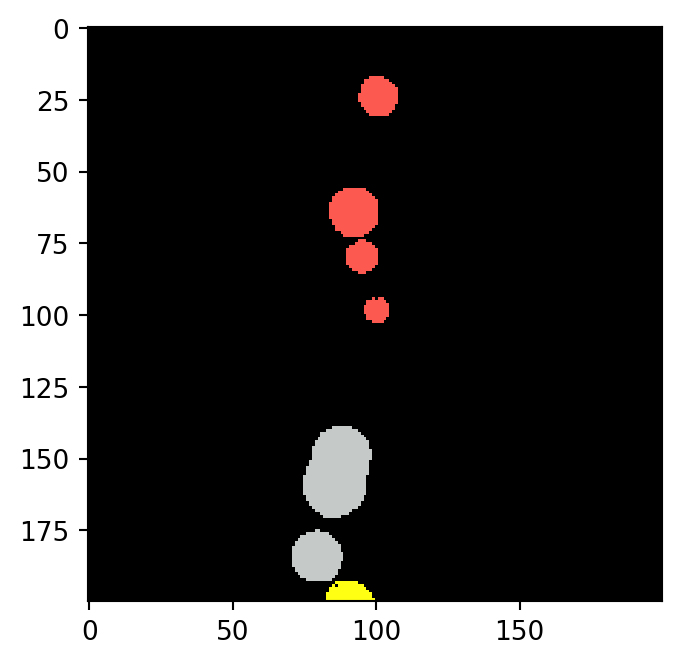

In [40]:
def draw_traj(dendros):
    colors = ["black", "aqua", "coral", "chartreuse", "azure",
              "beige", "goldenrod", "brown", "lavender",
              "fuchsia", "silver", "ivory", "yellow"]
    colors = [mcd.XKCD_COLORS["xkcd:" + c] for c in colors]
    newcmp = ListedColormap(colors)
    
    for t in range(len(dendros)):
        im = np.zeros((200, 200))
        for b in dendros[t].branches:
            if b.mass_frac > 0.9:
                for loc in b.full_region:
                    im[loc] = b.traj_id/12
        plt.imshow(im, cmap=newcmp)
        plt.savefig("traj-{:02d}.png".format(t))
        
draw_traj(dendros)

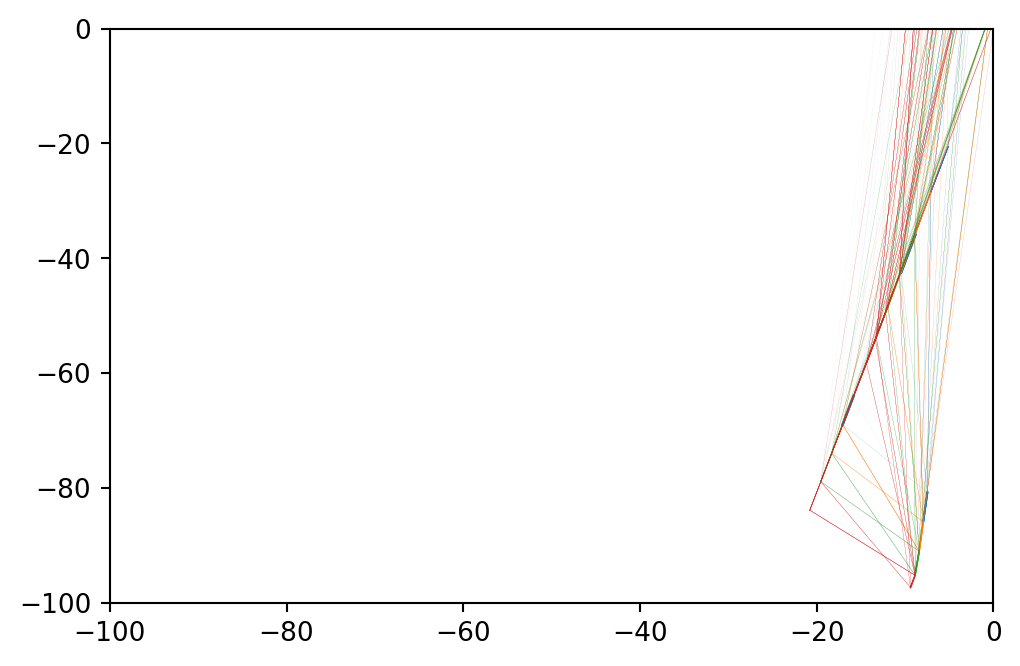

In [6]:
def draw_traj(opt, dendros, xbound=(-100,100), ybound=(-100,100)):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for t in range(len(dendros)-1):
        cur_d = dendros[t].branches
        next_d = dendros[t+1].branches
        links = softmax(opt[t], axis=2)
        color = colors[t%len(colors)]
        for _, i, j in np.ndindex(*links.shape):
            x = [cur_d[i].loc[0], next_d[j].loc[0]]
            y = [cur_d[i].loc[1], next_d[j].loc[1]]
            if cur_d[i].weight > 0.99 and next_d[j].weight > 0.99:
                plt.plot(x, y, linewidth=links[0,i,j], color=color)
    plt.xlim(xbound)
    plt.ylim(ybound)
    plt.show()

plt.close()
draw_traj(links, dendros, xbound=(-100,0), ybound=(-100,0))